# EDSA 2022 Classification Hackathon - South African Language Identification

**Overview**

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.
From South African Government

With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

# Honour Code

I **Christian Divinefavour**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the EDSA honour code.

Non-compliance with the honour code constitutes a material breach of contract.


# Problem Statement

With the divers official languages in South Africa, 11, precisely, a system is needed to effectively taken in texts in any of this languages and identify accurateky which language it's in; this is to aid general communal interaction in the country.


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Preprocessing</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Conclusion</a>

<a id="one"></a>
## 1. Importing Packages 

In [1]:

#import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


<a id = "two"></a>
## 2. Loading Data

**Load** **original** **data**

In [2]:
df_train = pd.read_csv('train_set.csv')
df_test = pd.read_csv('test_set.csv')
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [3]:
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


**Create a copy of data for further analysis and grouping by distinct language**

In [4]:
train_copy = df_train.copy()
test_copy = df_test.copy()

<a id = "three"></a>
## 3. Exploratory Data Analysis

**Now that we've successfully loaded our data, let's see what we're working with; let's check for data types on train data**

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
lang_id    33000 non-null object
text       33000 non-null object
dtypes: object(2)
memory usage: 515.7+ KB


**Next, let's check for null values**

In [6]:
df_train.isnull().sum()

lang_id    0
text       0
dtype: int64

**There are no null values in the data frame. Let's check for unique values of lang_id**

In [7]:
unique_vals = df_train['lang_id'].unique()
count_of_unique_vals = df_train['lang_id'].nunique()

print(unique_vals, "\nThere are ", count_of_unique_vals, "unique values in total")

['xho' 'eng' 'nso' 'ven' 'tsn' 'nbl' 'zul' 'ssw' 'tso' 'sot' 'afr'] 
There are  11 unique values in total


**Let's visualize the how these languages occur in the data frame by plot the values**

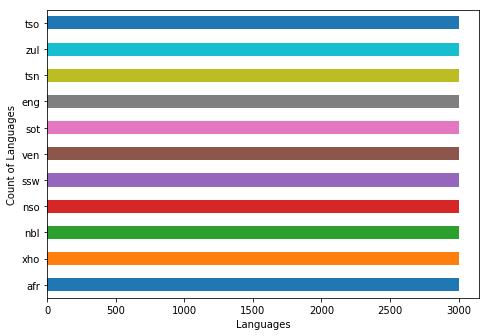

In [8]:
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
df_train['lang_id'].value_counts().plot(kind = 'barh')
ax.set_xlabel('Languages')
ax.set_ylabel('Count of Languages')
plt.show()


**It seems each language has 3000 entries. Let's confirming that by creating a dictionary to show each language and the number of occurences**

In [9]:
unique_plot = {}
for i in unique_vals:
    unique_plot[i] = df_train[df_train['lang_id'] == i]['lang_id'].count()
unique_plot

{'xho': 3000,
 'eng': 3000,
 'nso': 3000,
 'ven': 3000,
 'tsn': 3000,
 'nbl': 3000,
 'zul': 3000,
 'ssw': 3000,
 'tso': 3000,
 'sot': 3000,
 'afr': 3000}

**Clearly they have 3000 entries, each**

**Let us now visualize what the words look like, using word clouds.**

1. Group the data into a list of 11 dataframes of the unique languages
2. Visualize, using word cloud

In [10]:
column_list = [train_copy[train_copy['lang_id'] == j] for j in unique_vals]
column_list

[      lang_id                                               text
 0         xho  umgaqo-siseko wenza amalungiselelo kumaziko ax...
 1         xho  i-dha iya kuba nobulumko bokubeka umsebenzi na...
 28        xho  langa eli xesha nesizathu salo zingasinika ama...
 43        xho  abafaki-zicelo abadla umhlala-phantsi ncedani ...
 59        xho  intsilelo ligcisa ukthobela ukuziphatha okumis...
 73        xho  umntwana wakho ufanele ukuwonwabela lo msebenz...
 79        xho  ubuchule benkonzo zamanzi buthetha nawuphi umh...
 138       xho  umlawuli-jikelele uya kuthatha amanyathelo ang...
 147       xho  iinkqubo zeemvavanyo ezijoliswe kubemi bamazwe...
 157       xho  ipilisi yocwangciso-ntsapho olungxamisekileyo ...
 178       xho  imimiselo yikuziphatha komsebenzi wenkono yolu...
 180       xho  iikliniki zethu ezikwiidolophu ezincinci zinik...
 193       xho  ukuba umdala kakhulu okanye uyagula kakhulu uk...
 199       xho  umlawuli kamasipala njengegosa elongamele ulaw...
 213      

Text(0.5, 1.0, 'AFR')

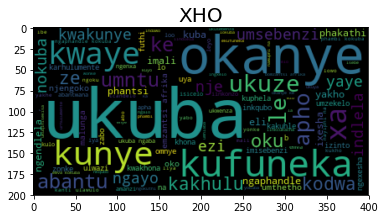

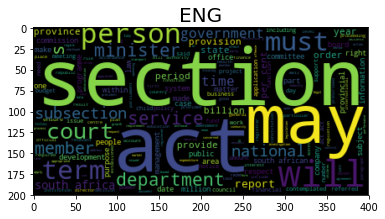

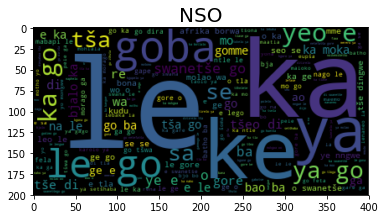

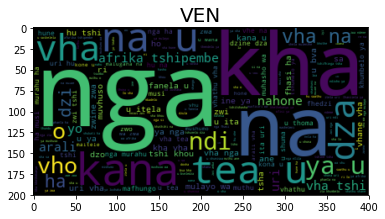

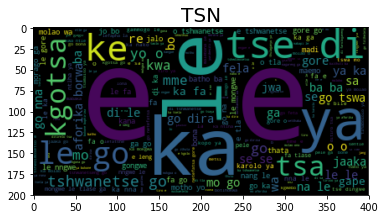

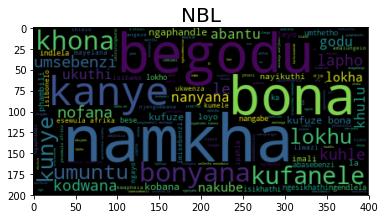

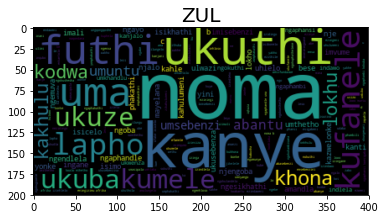

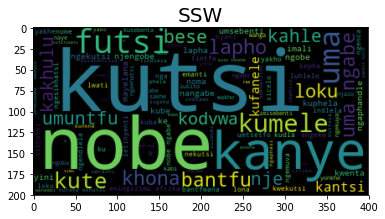

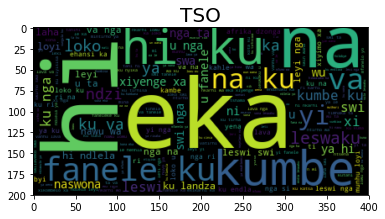

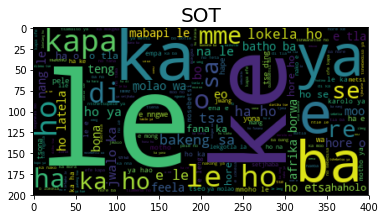

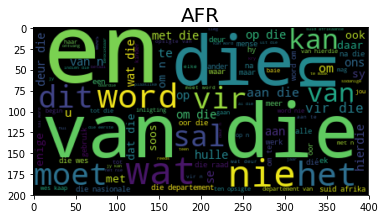

In [11]:
#xho' 'eng' 'nso' 'ven' 'tsn' 'nbl' 'zul' 'ssw' 'tso' 'sot' 'afr'
#--VISUALIZATION
xho = train_copy[(train_copy['lang_id'] == 'xho')]
eng = train_copy[(train_copy['lang_id'] == 'eng')]
nso = train_copy[(train_copy['lang_id'] == 'nso')]
ven = train_copy[(train_copy['lang_id'] == 'ven')]
tsn = train_copy[(train_copy['lang_id'] == 'tsn')]
nbl = train_copy[(train_copy['lang_id'] == 'nbl')]
zul = train_copy[(train_copy['lang_id'] == 'zul')]
ssw = train_copy[(train_copy['lang_id'] == 'ssw')]
tso = train_copy[(train_copy['lang_id'] == 'tso')]
sot = train_copy[(train_copy['lang_id'] == 'sot')]
afr = train_copy[(train_copy['lang_id'] == 'afr')]

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(xho.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('XHO',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(eng.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('ENG',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(nso.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('NSO',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(ven.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('VEN',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(tsn.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('TSN',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(nbl.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('NBL',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(zul.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('ZUL',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(ssw.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('SSW',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(tso.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('TSO',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(sot.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('SOT',fontsize=20)

plt.figure()
wc = WordCloud(max_words = 200).generate(" ".join(afr.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('AFR',fontsize=20)

<a id="four"></a>
# 4. Data Processing

Let's get to clean the data.

In [12]:
nltk.download('stopwords')
stop = stopwords.words('english')
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Christian-
[nltk_data]     Khane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
nltk.download('wordnet')
from bs4 import BeautifulSoup
def review_to_words(raw_message):
    # 1. Delete HTML 
    message_text = BeautifulSoup(raw_message, 'html.parser').get_text()
    #letters2 =raw_message.replace('http\S+|www.\S+', '', case=False)
    # 2. Make a space
    letters3 = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', message_text)
    letters_only = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))', '', letters3, flags=re.MULTILINE)
    letters = re.sub('[^a-zA-Z]', ' ',  letters_only)
    letters1 = re.sub(r'http', ' ', letters)
    
    #letters2 = re.sub("\n", "", letters1)
     
    # 3. lower letters
    words = letters1.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

[nltk_data] Downloading package wordnet to C:\Users\Christian-
[nltk_data]     Khane\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
df_train['cleaned_text'] = df_train['text'].apply(review_to_words)
df_test['cleaned_text'] = df_test['text'].apply(review_to_words)

In [15]:
df_test.head()

,index,text,cleaned_text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...",mmasepala fa maemo kgethegileng letlelela kgat...
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,tshivhumbeo tshi fana na ngano dza vhathu
3,4,Kube inja nelikati betingevakala kutsi titsini...,kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.,winste op buitelandse valuta


In [16]:
use_train = df_train[['lang_id', 'cleaned_text']]
use_test = df_test['cleaned_text']

use_train.head()

,lang_id,cleaned_text
0,xho,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,dha iya kuba nobulumko bokubeka umsebenzi naph...
2,eng,province kwazulu natal department transport in...
3,nso,netefat gore ba file dilo ka moka e le dumelel...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [17]:
use_test.head()

0    mmasepala fa maemo kgethegileng letlelela kgat...
1    uzakwaziswa ngokufaneleko nakungafuneka eminye...
2            tshivhumbeo tshi fana na ngano dza vhathu
3    kube inja nelikati betingevakala kutsi titsini...
4                         winste op buitelandse valuta
Name: cleaned_text, dtype: object

In [18]:
X = use_train['cleaned_text']
y = use_train['lang_id']

X.head()

0    umgaqo siseko wenza amalungiselelo kumaziko ax...
1    dha iya kuba nobulumko bokubeka umsebenzi naph...
2    province kwazulu natal department transport in...
3    netefat gore ba file dilo ka moka e le dumelel...
4    khomishini ya ndinganyiso ya mbeu yo ewa maana...
Name: cleaned_text, dtype: object

In [19]:
X_train, X_test, y_train, y_test= train_test_split(X, y, stratify=y,test_size=0.1, random_state=0)

# Vectorization

In [20]:
count_vectorizer = CountVectorizer(stop_words='english')

vec_train = count_vectorizer.fit_transform(X_train)
vec_test = count_vectorizer.transform(X_test)

use_vectest = count_vectorizer.transform(use_test)

In [21]:
vec_train.shape

(29700, 130062)

In [22]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.2)

vec_train2 = tfidf_vectorizer.fit_transform(X_train)
vec_test2 = tfidf_vectorizer.transform(X_test)

use_vectest2 = tfidf_vectorizer.transform(use_test)

In [23]:
vec_train2.shape

(29700, 130059)

<a id="five"></a>
# 5. Modeling

## Naive Bayes and Count Vectorizer

In [24]:
##---Naive Bayes & Count Vectorizer

from sklearn.naive_bayes import MultinomialNB

mNB = MultinomialNB()
mNB.fit(vec_train, y_train)
pred1 = mNB.predict(vec_test)

print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       300
         eng       1.00      1.00      1.00       300
         nbl       1.00      1.00      1.00       300
         nso       1.00      1.00      1.00       300
         sot       1.00      1.00      1.00       300
         ssw       1.00      1.00      1.00       300
         tsn       1.00      1.00      1.00       300
         tso       1.00      1.00      1.00       300
         ven       1.00      1.00      1.00       300
         xho       1.00      1.00      1.00       300
         zul       1.00      1.00      1.00       300

   micro avg       1.00      1.00      1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [25]:
sub1 = mNB.predict(use_vectest)

submission1 = df_test[['index']]
submission1['lang_id']= sub1
submission1.to_csv('submission1.csv', index = None)

C:\Users\Christian-Khane\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Naive Bayes & TFIDF Vectorizer

In [27]:
##---Naive Bayes & TFIDF Vectorizer

mNB = MultinomialNB()
mNB.fit(vec_train2, y_train)
pred1b = mNB.predict(vec_test2)

print(classification_report(y_test, pred1b))

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       300
         eng       1.00      1.00      1.00       300
         nbl       1.00      1.00      1.00       300
         nso       1.00      1.00      1.00       300
         sot       1.00      1.00      1.00       300
         ssw       1.00      1.00      1.00       300
         tsn       1.00      1.00      1.00       300
         tso       1.00      1.00      1.00       300
         ven       1.00      1.00      1.00       300
         xho       1.00      1.00      1.00       300
         zul       1.00      1.00      1.00       300

   micro avg       1.00      1.00      1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [28]:
sub1b = mNB.predict(use_vectest2)

submission1b = df_test[['index']]
submission1b['lang_id']= sub1b
submission1b.to_csv('submission1b.csv', index = None)

C:\Users\Christian-Khane\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Logistic Regression and Count Vectorizer

In [29]:
LR = LogisticRegression()
LR.fit(vec_train, y_train)
pred2 = LR.predict(vec_test)

print(classification_report(y_test, pred2))

C:\Users\Christian-Khane\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Christian-Khane\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       300
         eng       1.00      1.00      1.00       300
         nbl       0.99      0.99      0.99       300
         nso       1.00      1.00      1.00       300
         sot       1.00      1.00      1.00       300
         ssw       0.99      0.99      0.99       300
         tsn       1.00      1.00      1.00       300
         tso       1.00      1.00      1.00       300
         ven       1.00      1.00      1.00       300
         xho       1.00      1.00      1.00       300
         zul       0.99      0.99      0.99       300

   micro avg       1.00      1.00      1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [30]:
sub2 = LR.predict(use_vectest)

submission2 = df_test[['index']]
submission2['lang_id']= sub2
submission2.to_csv('submission2.csv', index = None)

C:\Users\Christian-Khane\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Logistic Regression and TFIDF Vectorizer

In [31]:
LR = LogisticRegression()
LR.fit(vec_train2, y_train)
pred2b = LR.predict(vec_test2)

print(classification_report(y_test, pred2b))

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       300
         eng       1.00      1.00      1.00       300
         nbl       1.00      0.99      0.99       300
         nso       1.00      1.00      1.00       300
         sot       1.00      1.00      1.00       300
         ssw       0.99      0.99      0.99       300
         tsn       1.00      1.00      1.00       300
         tso       1.00      1.00      1.00       300
         ven       1.00      1.00      1.00       300
         xho       0.99      1.00      1.00       300
         zul       0.99      0.99      0.99       300

   micro avg       1.00      1.00      1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [32]:
sub2b = LR.predict(use_vectest2)

submission2b = df_test[['index']]
submission2b['lang_id']= sub2b
submission2b.to_csv('submission2b.csv', index = None)

C:\Users\Christian-Khane\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Random Forest and Count Vectorizer

In [33]:
RF = RandomForestClassifier(n_estimators=2, random_state=0)
RF.fit(vec_train, y_train)
pred3 = RF.predict(vec_test)

print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

         afr       0.97      1.00      0.99       300
         eng       0.96      0.99      0.98       300
         nbl       0.72      0.91      0.80       300
         nso       0.71      0.96      0.81       300
         sot       0.79      0.85      0.82       300
         ssw       0.76      0.86      0.81       300
         tsn       0.93      0.57      0.70       300
         tso       0.97      0.96      0.96       300
         ven       1.00      0.96      0.98       300
         xho       0.83      0.86      0.84       300
         zul       0.93      0.49      0.64       300

   micro avg       0.85      0.85      0.85      3300
   macro avg       0.87      0.85      0.85      3300
weighted avg       0.87      0.85      0.85      3300



In [34]:
sub3 = RF.predict(use_vectest)

submission3 = df_test[['index']]
submission3['lang_id']= sub3
submission3.to_csv('submission3.csv', index = None)

C:\Users\Christian-Khane\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## Random Forest and TFIDF Vectorizer

In [35]:
RF = RandomForestClassifier(n_estimators=2, random_state=0)
RF.fit(vec_train2, y_train)
pred3b = RF.predict(vec_test2)

print(classification_report(y_test, pred3b))

              precision    recall  f1-score   support

         afr       0.98      1.00      0.99       300
         eng       0.96      0.98      0.97       300
         nbl       0.69      0.89      0.78       300
         nso       0.73      0.96      0.83       300
         sot       0.85      0.87      0.86       300
         ssw       0.85      0.89      0.87       300
         tsn       0.90      0.66      0.76       300
         tso       0.99      0.97      0.98       300
         ven       0.99      0.97      0.98       300
         xho       0.84      0.81      0.82       300
         zul       0.86      0.53      0.66       300

   micro avg       0.87      0.87      0.87      3300
   macro avg       0.88      0.87      0.86      3300
weighted avg       0.88      0.87      0.86      3300



In [36]:
sub3b = RF.predict(use_vectest2)

submission3b = df_test[['index']]
submission3b['lang_id']= sub3b
submission3b.to_csv('submission3b.csv', index = None)

C:\Users\Christian-Khane\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<a id="six"></a>
# 6. Model Performance

##### Models used performed good on the train data, we can see that from the F1 scores. However, on testing and submitting on Kaggle, the Naive Bayes models performed best, with the count vectorizer technique.

# 7. Conclusion

#### In conclusion, we have shown that NLP can successfully be used to identify what language a text is written in. To futher improve our model, more data is required, knowledge of stopwords in other languages may also be an added advantage.